In [ ]:
!pip install medmnist scikit-learn matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

import medmnist
from medmnist import INFO

device = torch.device("cpu")

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(8),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

dataset = DataClass(split='train', transform=transform_train, download=True)
test_dataset = DataClass(split='test', transform=transform_test, download=True)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
labels = np.array(dataset.labels).flatten()

# Get labels for the training subset
train_subset_labels = labels[train_dataset.indices]

# Calculate class counts and weights specific to the training subset
train_class_counts = np.bincount(train_subset_labels)
train_weights = 1. / train_class_counts
train_sample_weights = train_weights[train_subset_labels]

# Create WeightedRandomSampler for the training data
sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class weights for the loss function should also reflect the training set distribution
class_weights = torch.tensor(train_weights, dtype=torch.float32).to(device)

In [ ]:
class MiniTransformer(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads=4, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out,_ = self.attn(x,x,x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ff(x))
        return x

In [ ]:
class CNNBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )

    def forward(self,x):
        x = self.features(x)
        return torch.flatten(x,1)

In [ ]:
class ViTBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1,64,3,padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.transformer = MiniTransformer(64)

    def forward(self,x):
        x = self.pool(self.conv(x))
        b,c,h,w = x.shape
        x = x.view(b,c,h*w).permute(0,2,1)
        x = self.transformer(x)
        x = torch.mean(x,dim=1)
        return x

In [ ]:
class HybridEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = CNNBranch()
        self.vit = ViTBranch()

        self.fc = nn.Sequential(
            nn.Linear(64*4*4 + 64,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,2)
        )

    def forward(self,x):
        f1 = self.cnn(x)
        f2 = self.vit(x)
        fused = torch.cat([f1,f2],dim=1)
        return self.fc(fused)

In [ ]:
model = HybridEnsemble().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
def train_epoch(loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
def evaluate(loader):
    model.eval()
    preds, probs, targets = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            probability = torch.softmax(outputs,1)[:,1]
            prediction = torch.argmax(outputs,1)

            preds.extend(prediction.cpu().numpy())
            probs.extend(probability.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets,preds)
    precision = precision_score(targets,preds)
    recall = recall_score(targets,preds)
    f1 = f1_score(targets,preds)
    auc = roc_auc_score(targets,probs)

    return acc,precision,recall,f1,auc,targets,preds

In [ ]:
for epoch in range(8):
    loss = train_epoch(train_loader)
    scheduler.step()

    acc,prec,rec,f1,auc,_,_ = evaluate(val_loader)

    print(f"Epoch {epoch+1}")
    print("Loss:",loss)
    print("Val Accuracy:",acc)
    print("Precision:",prec)
    print("Recall:",rec)
    print("F1:",f1)
    print("AUC:",auc)

Epoch 1
Loss: 0.10480777112672389
Val Accuracy: 0.881104033970276
Precision: 0.993517017828201
Recall: 0.8502080443828016
F1: 0.9162929745889388
AUC: 0.9865822355828068
Epoch 2
Loss: 0.11839910228815624
Val Accuracy: 0.9363057324840764
Precision: 0.9896296296296296
Recall: 0.926490984743412
F1: 0.9570200573065902
AUC: 0.9875236128805518
Epoch 3
Loss: 0.10874304831248977
Val Accuracy: 0.9087048832271762
Precision: 0.9937791601866252
Recall: 0.8862690707350902
F1: 0.9369501466275659
AUC: 0.9875236128805517
Epoch 4
Loss: 0.11232885937758927
Val Accuracy: 0.940552016985138
Precision: 0.9940564635958395
Recall: 0.9278779472954231
F1: 0.9598278335724534
AUC: 0.988941954675821
Epoch 5
Loss: 0.09381928015500307
Val Accuracy: 0.9267515923566879
Precision: 0.9924471299093656
Recall: 0.9112343966712899
F1: 0.9501084598698482
AUC: 0.9888478169460465
Epoch 6
Loss: 0.0991936916864272
Val Accuracy: 0.9288747346072187
Precision: 0.9924698795180723
Recall: 0.9140083217753121
F1: 0.9516245487364621
AUC:

True Negatives (TN): 189
False Positives (FP): 45
False Negatives (FN): 22
True Positives (TP): 368


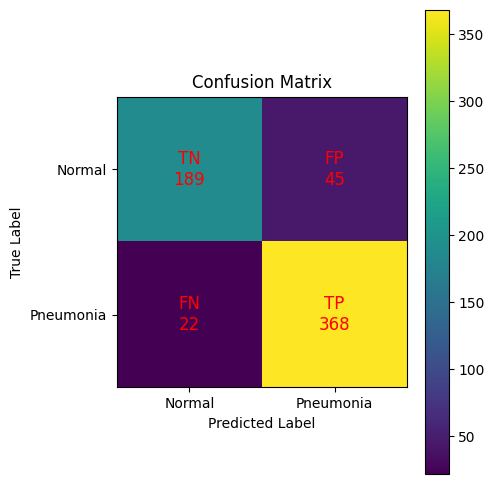

In [ ]:
import numpy as np

# Evaluate on test set
acc,prec,rec,f1,auc,targets,preds = evaluate(test_loader)

# Confusion matrix
cm = confusion_matrix(targets, preds)

tn, fp, fn, tp = cm.ravel()

print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

# Plot confusion matrix with labels
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

labels = np.array([
    [f"TN\n{tn}", f"FP\n{fp}"],
    [f"FN\n{fn}", f"TP\n{tp}"]
])

for i in range(2):
    for j in range(2):
        plt.text(j, i, labels[i, j],
                 ha="center", va="center", color="red", fontsize=12)

plt.xticks([0,1], ["Normal", "Pneumonia"])
plt.yticks([0,1], ["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:",params)

Trainable parameters: 184322


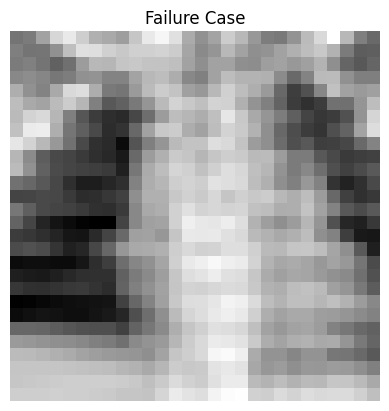

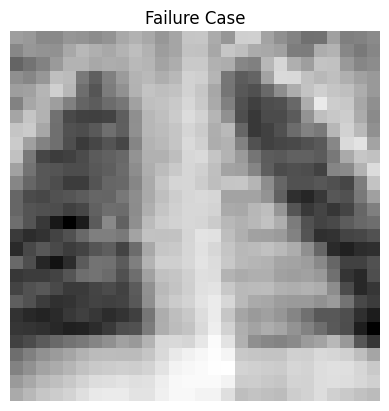

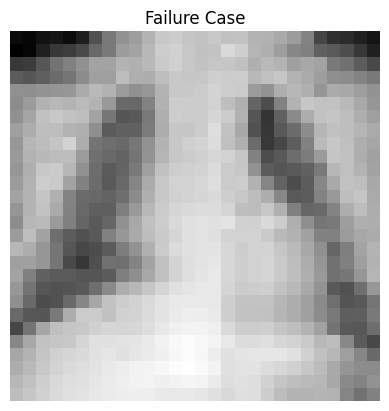

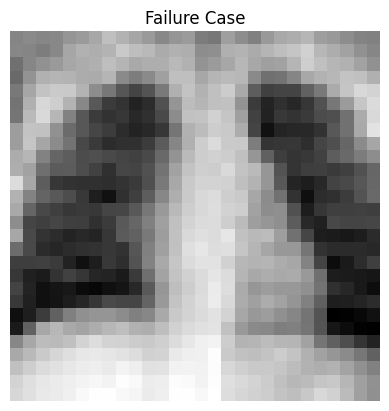

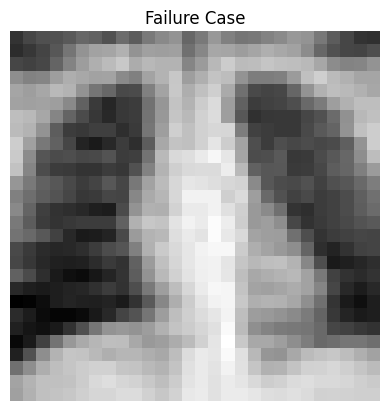

In [ ]:
model.eval()
fail_images = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = torch.argmax(outputs,1)
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                fail_images.append(images[i])
        if len(fail_images) >= 5:
            break

for i,img in enumerate(fail_images[:5]):
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Failure Case")
    plt.axis('off')
    plt.show()